In [1]:
import os, sys, torch, json, time, string, re, pickle, unicodedata, numpy as np, unicodedata
import torch.optim as optim, torch, torch.nn as nn, torch.nn.functional as F
import torch, torch.nn as nn, torch.nn.functional as func, evaluate as ev, time
from tqdm import tqdm
from torch import matmul
from torch.nn.functional import dropout
from torch import LongTensor,ByteTensor
from torch.utils.data import Dataset
from torch.autograd import Variable

random_seed = 11
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

In [2]:
#Load processed datasets without topics

train_exs = []
dev_exs = []

f = open("data/datasets_without_topics_new/train-v1.1-processed.txt", 'r')
for line in tqdm(f):
    example = json.loads(line)
    if len(example['ans'])>0:
        train_exs.append(example)
f.close()

f1 = open("data/datasets_without_topics_new/dev-v1.1-processed.txt", 'r')
for line in tqdm(f1):
    example = json.loads(line)
    if len(example['ans'])>0:
        dev_exs.append(example)
f1.close()

time.sleep(1)
print('Num train examples = %d' % len(train_exs))
print('Num dev examples = %d' % len(dev_exs))

87599it [00:24, 3525.37it/s]
10570it [00:04, 2371.22it/s]


Num train examples = 86422
Num dev examples = 10493


In [3]:
time.sleep(1)
dev_offsets = {ex['id']: ex['ans_pos'] for ex in dev_exs}
print(time.ctime() + " Build word o index mapping")
time.sleep(1)

samples = train_exs + dev_exs
word2idx = {'<NULL>':0, '<UNK>':1} 
char2idx = {'<NULL>':0, '<UNK>':1}

word_set = set()
char_set = set()
feature_set = set()
for each_example in tqdm(samples):
    
    for word in each_example['question']:
        word_set.add(word)

    for word in each_example['ctxt']:
        word_set.add(word)

    for char in each_example['ques_char']:
        char_set.add(char)

    for char in each_example['ctxt_char']:
        char_set.add(char)

        
print(time.ctime() + " word_set")

for i, word in enumerate(word_set):
    if word not in word2idx.keys():
        word2idx[word] = i+2


for i, char in enumerate(char_set):
    if char not in char2idx.keys():
        char2idx[char] = i+2

print('#words', len(word2idx))    
print('#chars', len(char2idx))

Load Dev val
Mon May  7 13:44:01 2018 Build feature dict train


100%|██████████| 96915/96915 [00:04<00:00, 20178.00it/s]


Mon May  7 13:44:07 2018 word_set
#words 123198
#chars 756


In [4]:
def load_embeddings(word2idx,char2idx,glove_file):
    
    corpus_words = set()
    for key in word2idx.keys():
        if key not in {'<NULL>','<UNK>'}:
            corpus_words.add(key)
    
    corpus_chars = set()
    for key in char2idx.keys():
        if key not in {'<NULL>','<UNK>'}:
            corpus_chars.add(key)
            
    idx2word = {v: k for k, v in char2idx.items()}
    idx2char = {v: k for k, v in char2idx.items()}
    
    glove_big = {}
    with open(glove_file, "rb") as infile:
        for line in infile:
            parts = line.split()
            word = parts[0].decode()#.lower()
            nums = map(float, parts[1:])
            if (word in corpus_words) or (word in corpus_chars):
                glove_big[word] = list(nums)
                
    idx2word = {v: k for k, v in word2idx.items()}
    
    weights_matrix = np.random.normal(scale=0.6, size=(len(idx2word), 300))#np.zeros((len(idx2word), 300))
    words_found = 0

    for word in corpus_words:
        if word in glove_big.keys():
            weights_matrix[word2idx[word]] = glove_big[word]
            words_found += 1
    print("%d words found out of %d" %(words_found, len(idx2word)))

    weights_matrix_char = np.random.normal(scale=0.6, size=(len(idx2char), 300))#np.zeros((len(idx2word), 300))
    chars_found = 0

    for char in corpus_chars:
        if char in glove_big.keys():
            weights_matrix[char2idx[char]] = glove_big[char]
            chars_found += 1
    print("%d chars found out of %d" %(chars_found, len(idx2char)))
    
    return weights_matrix, weights_matrix_char

In [5]:
weights_matrix, weights_matrix_char = load_embeddings(word2idx,char2idx,'data/glove.840B.300d.txt')

emb_layer = nn.Embedding(num_embeddings= len(word2idx), embedding_dim = 300, padding_idx=0).cuda()
emb_layer.weight.data.copy_(torch.from_numpy(weights_matrix))

emb_layer_char = nn.Embedding(num_embeddings= len(char2idx), embedding_dim = 300, padding_idx=0).cuda()
emb_layer_char.weight.data.copy_(torch.from_numpy(weights_matrix_char))

emb_layer.weight.requires_grad = False
emb_layer_char.weight.requires_grad = False

98175 words found out of 123198
262 chars found out of 756


In [6]:
'''
Creating features
'''
class Transform(Dataset):
    def __init__(self, example, word2idx, char2idx,status):#feature2idx
        self.example = example
        self.status = status
        self.word2idx =  word2idx
        self.char2idx =  char2idx
        
        self.feature2idx = {'RB': 4,'DT': 5,'NN': 6,'VBZ': 7,'JJ': 8,'LS': 9,'VB': 10,'NNP': 11,'POS': 12,'IN': 13,'CC': 14,'VBG': 15,'PRP': 16,'NNS': 17,'VBN': 18,'TO': 19,'WRB': 20,
        'VBD': 21,'CD': 22,'PDT': 23,'WDT': 24,'WP': 25,'VBP': 26,'UH': 27,'ORG': 28,'FACILITY': 29,'GPE': 30,'PERSON': 31,'JJS': 32,'NNPS': 33,
        'RP': 34,'LOCATION': 35,'FW': 36,'JJR': 37,'RBS': 38,'MD': 39,'SYM': 40,'EX': 41,'RBR': 42,'GSP': 43}
        
    def __len__(self):
        return len(self.example)

    def __getitem__(self, index):
        
        ctxt = self.example[index]['ctxt']
        ques = self.example[index]['question']
        ctxt_char = self.example[index]['ctxt_char']
        question_char = self.example[index]['ques_char']
        total_length_context = len(ctxt)
        total_length_question = len(ques)
        
        cpos_d = self.example[index]['ctxt_pos']
        cner_d = self.example[index]['ctxt_ner']
        qpos_d = self.example[index]['ques_pos']
        qner_d = self.example[index]['qner']
        
        context_cased = set(ctxt) #all words in context
        context_uncased = set([word.lower() for word in ctxt]) #all words in context lowercase
        word_ques = [self.word2idx.get(word, 1) for word in ques] # get index of question word
        word_con = [self.word2idx.get(word, 1) for word in ctxt] # get index of context word
        ques_cased = set(ques)
        ques_uncased = set([element.lower() for element in ques])
        char_ques = [self.char2idx.get(char, 1) for char in question_char]
        char_con = [self.char2idx.get(char, 1) for char in ctxt_char]
        context_lemmas = set(self.example[index]['ctxt_lemma'])
        ques_lemmas = set(self.example[index]['qlemma'])
        count_of_word_context = {word.lower(): ctxt.count(word.lower()) for word in ctxt}
        count_of_word_question = {word.lower(): ques.count(word.lower()) for word in ques}
        
        #creating question and context feature vector
        context_feature = torch.zeros(len(ctxt), 44)
        ques_feature = torch.zeros(len(ques), 44)
        
        #exact match features being one 
        for i in range(len(ctxt)):
            if ctxt[i] in ques_cased:
                context_feature[i][0] = 1.0
            if ctxt[i] in ques_uncased:
                context_feature[i][1] = 1.0
            if ctxt[i] in ques_lemmas:
                context_feature[i][2] = 1.0
            
        for i in range(len(cpos_d)):
            f = cpos_d[i]
            if f in self.feature2idx:
                context_feature[i][self.feature2idx[f]] = 1.0
            
        for i in range(len(cner_d)):
            f = cner_d[i]
            if f in self.feature2idx:
                context_feature[i][self.feature2idx[f]] = 1.0
        
        for i in range(len(qpos_d)):
            f = qpos_d[i]
            if f in self.feature2idx:
                ques_feature[i][self.feature2idx[f]] = 1.0
            
        for i in range(len(qner_d)):
            f = qner_d[i]
            if f in self.feature2idx:
                ques_feature[i][self.feature2idx[f]] = 1.0

        for i in range(len(ques)):
            if ques[i] in ques_cased:
                ques_feature[i][0] = 1.0
            if ques[i] in ques_uncased:
                ques_feature[i][1] = 1.0
            if ques[i] in ques_lemmas:
                ques_feature[i][2] = 1.0
            
        for i in range(total_length_context):
            context_feature[i][3] = float(count_of_word_context[ctxt[i].lower()]/(1.0 * total_length_context))
        
        for i in range(total_length_question):
            ques_feature[i][3] = float(count_of_word_question[ques[i].lower()]/ (1.0 * total_length_question))

        if self.status == 'train': # take only the first answer
            start_positions = LongTensor(1).fill_(self.example[index]['ans'][0][0])
            end_positions = LongTensor(1).fill_(self.example[index]['ans'][0][1])
        else: # consider all answers while evaluating
            start_positions = []
            end_positions = []
            for ans in self.example[index]['ans']:
                start_positions.append(ans[0])
                end_positions.append(ans[1])
                
        return LongTensor(word_con), LongTensor(char_con), context_feature, LongTensor(word_ques), LongTensor(char_ques), ques_feature, start_positions, end_positions, self.example[index]['id']

In [7]:
train_dataset = Transform(train_exs, word2idx, char2idx, status='train') #feature2idx,
train_sampler = torch.utils.data.sampler.RandomSampler(train_dataset)
dev_dataset = Transform(dev_exs, word2idx, char2idx, status='test') #feature2idx,
dev_sampler = torch.utils.data.sampler.SequentialSampler(dev_dataset)
print(len(dev_dataset))

10493


In [8]:
'''
padding batches to same length
'''
def module_fn(batch_len, con_features, con_words, con_char,max_len): #
    con1_words = LongTensor(batch_len,max_len).zero_() #N X max_len
    con1_chars = LongTensor(batch_len,max_len).zero_()
    con1_features = torch.zeros(batch_len,max_len,con_features[0].size(1))

    for i in range(batch_len):
        con1_words[i,0:con_words[i].size(0)].copy_(con_words[i])
        con1_chars[i, 0:con_char[i].size(0)].copy_(con_char[i])
        con1_features[i,:con_words[i].size(0)].copy_(con_features[i])

    return con1_words, con1_chars, con1_features, #con1_masked_val

def pad_batch(batch):
    
    con_words = []
    con_char = []
    con_features = []
    ques_words = []
    ques_char = []
    ques_features = []
    ids = []

    length_con = []
    length_ques = []
    for val in batch:
        con_words.append(val[0])
        length_con.append(val[0].size(0))
        con_char.append(val[1])
        con_features.append(val[2])
        ques_words.append(val[3])
        length_ques.append(val[3].size(0))
        ques_char.append(val[4])
        ques_features.append(val[5])
        ids.append(val[len(val)-1])

    if torch.is_tensor(batch[0][6]): #train
        abc1 = []
        abc2 = []
        for val in batch:
            abc1.append(val[6])
            abc2.append(val[7])
        batch_start_positions = torch.cat(abc1)
        batch_end_positions = torch.cat(abc2)
    else:        #eval mode
        batch_start_positions = []
        batch_end_positions = []
        for val in batch:
            batch_start_positions.append(val[6])
            batch_end_positions.append(val[7])
    return (*module_fn(len(batch), con_features, con_words, con_char,max(length_con))),length_con,(*module_fn(len(batch), ques_features, ques_words, ques_char,max(length_ques))), length_ques, batch_start_positions, batch_end_positions, ids


In [9]:
train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=45, sampler=train_sampler, num_workers=5, collate_fn=pad_batch, pin_memory=True,)
#change to 45
dev_loader = torch.utils.data.DataLoader(
        dev_dataset, batch_size=32, sampler=dev_sampler, num_workers=5, collate_fn=pad_batch, pin_memory=True,)

In [10]:
def Attention(attn, con, ques): 
    
    if attn == 'interac': 
        coattn = matmul(con, ques.transpose(2,1))    
    else: 
        coattn = matmul(ques, ques.transpose(2,1))
        #set diagonal elements to 0
        for i in range(coattn.size(0)):
            mask = torch.diag(torch.ones(min(coattn.size(1),coattn.size(2)))).cuda()
            coattn[i, :, :].data = mask*0 + (1. - mask)*coattn[i, :, :].data
            
    attn_dist = func.softmax(coattn, dim=2) #attention distribution of query for jth context word
    attended = matmul(attn_dist, ques) #attended query vector for all context words
    return attended

def encode(rnn, seq, lengths, flag):
    
    key=sorted(range(len(lengths)), key=lambda k: lengths[k], reverse=True)

    seq = seq.index_select(0, Variable(torch.LongTensor(key).cuda())).transpose(0, 1)
    rnn_input = nn.utils.rnn.pack_padded_sequence(seq, sorted(lengths, reverse=True))
    rev_key = sorted(range(len(key)), key=lambda k: key[k])
    dropout_input = func.dropout(rnn_input.data, p=0.2, training=flag)
    rnn_input = nn.utils.rnn.PackedSequence(dropout_input, rnn_input.batch_sizes)
    output = rnn(rnn_input)[0]
    output = nn.utils.rnn.pad_packed_sequence(output)[0].transpose(0, 1).index_select(0, Variable(torch.LongTensor(rev_key).cuda()))
    output = func.dropout(output,p=0.2,training=flag)
    
    return output.contiguous() 

In [11]:
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        self.char_rnn = nn.LSTM(input_size=300, hidden_size=50, bidirectional=True)
        doc_input_size = 400 + 44
        self.encoding_rnn = nn.LSTM(input_size=doc_input_size, hidden_size=100, bidirectional=True)
        self.sfu_l1 = nn.ModuleList([nn.Linear(800,200),nn.Linear(800,200)])
        self.sfu_l2 = nn.ModuleList([nn.Linear(800,200),nn.Linear(800,200)])
        self.sfu_self_l1 = nn.ModuleList([nn.Linear(800,200),nn.Linear(800,200)])
        self.sfu_self_l2 = nn.ModuleList([nn.Linear(800,200),nn.Linear(800,200)])
        
        self.final_rec_nn = nn.ModuleList([nn.LSTM(input_size=200, hidden_size=100, bidirectional=True),nn.LSTM(input_size=200, hidden_size=100, bidirectional=True)])
        #
        FCN = nn.Sequential(
                nn.Linear(600, 100),
                nn.ReLU(inplace=True),
                nn.Dropout(0.2),
                nn.Linear(100, 1),)
        
        self.FeedForward_s = nn.ModuleList([FCN,FCN])
        self.sfu_s_l1 = nn.ModuleList([nn.Linear(400, 200),nn.Linear(400, 200)])
        self.sfu_s_l2 = nn.ModuleList([nn.Linear(400, 200),nn.Linear(400, 200)])
        self.FeedForward_e = nn.ModuleList([FCN,FCN])
        self.sfu_e_l1 = nn.ModuleList([nn.Linear(400, 200),nn.Linear(400, 200)])
        self.sfu_e_l2 = nn.ModuleList([nn.Linear(400, 200),nn.Linear(400, 200)])
        
        
    def forward(self, con_embed_words, con_embed_chars, con_feat, con_length, ques_embed_words, ques_embed_chars, ques_feat, ques_length):
       
        con_char_feat = encode(self.char_rnn, con_embed_chars, con_length, self.training) #encode context characters
        ques_char_feat = encode(self.char_rnn, ques_embed_chars, ques_length, self.training)#encode question characters
        val1 = torch.cat([con_embed_words,con_char_feat,con_feat], 2)#join all context features
        encoded_con = encode(self.encoding_rnn, val1, con_length, self.training)#encode context
        val2 = torch.cat([ques_embed_words,ques_char_feat,ques_feat], 2)#join all question features
        encoded_ques = encode(self.encoding_rnn, val2, ques_length, self.training)#encode question
        ctxt = encoded_con
        
        for i in range(2):
            #interactive aligning
            attended_ques = Attention('interac', ctxt, encoded_ques)
            #compute query aware representation
            val_s = torch.cat([ctxt, attended_ques, torch.mul(ctxt, attended_ques), ctxt - attended_ques], 2)
            comp = func.tanh(self.sfu_l1[i](val_s))
            gate = func.sigmoid(self.sfu_l2[i](val_s))
            ques_aware_ctxt = gate * comp + (1-gate) * ctxt #queey aware ctxt
            #self aligning
            attended_ctxt = Attention('self',0,ques_aware_ctxt)
            #compute context aware representation
            val_s = torch.cat([ques_aware_ctxt, attended_ctxt, torch.mul(ques_aware_ctxt,attended_ctxt), ques_aware_ctxt - attended_ctxt], 2)
            comp = func.tanh(self.sfu_self_l1[i](val_s))
            gate = func.sigmoid(self.sfu_self_l2[i](val_s))
            ctxt_aware_ctxt = gate * comp + (1-gate) * attended_ctxt # self-aware
            #Aggregating
            ctxt = encode(self.final_rec_nn[i], ctxt_aware_ctxt, con_length, self.training)
        
        #memory Answer Pointer
        memory_s = encoded_ques[:,-1,:].resize(encoded_ques.size(0),1, encoded_ques.size(2))
         
        for i in range(2):
            #prob dist for start using memory and fully aware context
            start = self.FeedForward_s[i](torch.cat([ctxt, memory_s.expand(-1,ctxt.size(1),-1), torch.mul(ctxt,memory_s.expand(-1,ctxt.size(1),-1))], 2))
            start_prob = func.softmax(start.squeeze(2), dim=1) 
            #evidence vector
            evidence_e = matmul(start_prob.unsqueeze(1),ctxt)
            
            #fuse memory and evidence
            val_s = torch.cat([memory_s, evidence_e], 2)
            l1_s = func.tanh(self.sfu_s_l1[i](val_s))
            gate = func.sigmoid(self.sfu_s_l2[i](val_s))
            memory_e = gate * l1_s + (1-gate) * memory_s #new memory
            
            #prob dist for end using new memory and fully aware context
            end = self.FeedForward_e[i](torch.cat([ctxt, memory_e.expand(-1,ctxt.size(1),-1), torch.mul(ctxt,memory_e.expand(-1,ctxt.size(1),-1))], 2))
            end_prob = func.softmax(end.squeeze(2), dim=1)
            #evidence vector
            evidence_e = matmul(end_prob.resize(end_prob.size(0),1, end_prob.size(1)),ctxt)
            
            # fuse to generate new memory
            val_e = torch.cat([memory_e, evidence_e], 2)
            l1_e = func.tanh(self.sfu_e_l1[i](val_e))
            gate_e = func.sigmoid(self.sfu_e_l2[i](val_e))
            memory_s = gate_e * l1_e + (1-gate_e) * memory_e

        start_prob = func.log_softmax(start.squeeze(2), dim=1) 
        end_prob = func.log_softmax(end.squeeze(2), dim=1)
        
        #print(end_prob.size())
        #print(start_prob.size())
    
        return start_prob, end_prob

In [12]:
# find mle
def findmax(score_s,score_e):
    max_len = 15
    pred_s = []
    pred_e = []
    dim = score_s.shape[1]
    
    for i in range(score_s.shape[0]):
        joint = np.zeros((dim,dim))
        for start in range(dim):
            if start+max_len < dim:
                joint[start,start:start+max_len]=score_s[i,:][start]*score_e[i,:][start:start+max_len]
            else:
                joint[start,start:dim] = score_s[i,:][start]*score_e[i,:][start:dim]
                
        s_idx, e_idx = np.argwhere(joint.max() == joint)[0,:] 
        
        pred_s.append(s_idx)
        pred_e.append(e_idx)
        
    return pred_s, pred_e

def validate(data_loader, network, positions, texts, answers, official):
    f1 = 0
    em = 0
    examples = 0
    results = {}
    for ex in data_loader:
        batch_size = ex[0].size(0)
        ex_id = ex[-1]
        
        #Predicting....
        network.eval()

        con_words = Variable(ex[0].cuda())
        con_chars = Variable(ex[1].cuda())
        con_feat = Variable(ex[2].cuda())
        ques_words = Variable(ex[4].cuda())
        ques_chars = Variable(ex[5].cuda())
        ques_feat = Variable(ex[6].cuda())

        con_embed_words = func.dropout(emb_layer(con_words), p=0.2)
        ques_embed_words = func.dropout(emb_layer(ques_words), p=0.2)
        con_embed_chars = func.dropout(emb_layer_char(con_chars), p=0.2)
        ques_embed_chars = func.dropout(emb_layer_char(ques_chars), p=0.2)

        score_s, score_e = network(con_embed_words,con_embed_chars,con_feat,ex[3],ques_embed_words,ques_embed_chars,ques_feat,ex[7])
        score_s.exp_() 
        score_e.exp_()
        pred_s, pred_e = findmax(score_s.data.cpu().numpy(),score_e.data.cpu().numpy())

        for i in range(batch_size):
            
            s_posn = positions[ex_id[i]][pred_s[i]][0]
            e_posn = positions[ex_id[i]][pred_e[i]][1]
            prediction = texts[ex_id[i]][s_posn:e_posn]
            
            if official:
                results[ex_id[i]]=prediction

            ground_truths = answers[ex_id[i]]
            em += ev.metric_max_over_ground_truths(ev.exact_match_score, prediction, ground_truths)
            f1 += ev.metric_max_over_ground_truths(ev.f1_score, prediction, ground_truths)
                 
        examples += batch_size
    
    if official:
        return f1/examples, em/examples, results
    else:
        return f1/examples, em/examples

In [13]:
# Initialize the model
reader = Model().cuda()
optimizer = optim.Adamax(reader.parameters())
torch.cuda.set_device(-1)
model_name = 'without_topics_final'

In [14]:
dev_texts = {}
dev_answers = {}
f2 = open("data/datasets_without_topics_new/dev-v1.1.json", 'r')
examples = json.load(f2)['data']
for article in tqdm(examples):
    for paragraph in article['paragraphs']:
        for qa in paragraph['qas']:
            dev_texts[qa['id']] = paragraph['context']
            dev_answers[qa['id']] = list(map(lambda x: x['text'], qa['answers']))
f2.close()

100%|██████████| 48/48 [00:00<00:00, 2479.12it/s]


In [15]:
#training
batch_size = 45
num_epochs = 14 
best_f1 = 0

loss_list = []
f1_list = []
em_list = []
epoch_list = []

for epoch in tqdm(range(0, num_epochs)):
    loss_list.append([])
    train_loss = 0
    for idx, ex in enumerate(train_loader): 

        reader.train()

        con_words = Variable(ex[0].cuda())
        con_chars = Variable(ex[1].cuda())
        con_feat = Variable(ex[2].cuda())
        ques_words = Variable(ex[4].cuda())
        ques_chars = Variable(ex[5].cuda())
        ques_feat = Variable(ex[6].cuda())
        target_start = Variable(ex[8].cuda())
        target_end = Variable(ex[9].cuda())
        
        con_embed_words = func.dropout(emb_layer(con_words), p=0.2)
        ques_embed_words = func.dropout(emb_layer(ques_words), p=0.2)
        con_embed_chars = func.dropout(emb_layer_char(con_chars), p=0.2)
        ques_embed_chars = func.dropout(emb_layer_char(ques_chars), p=0.2)
        
        pred_start, pred_end = reader(con_embed_words,con_embed_chars,con_feat,ex[3],ques_embed_words,ques_embed_chars,ques_feat,ex[7])
        
        loss = func.nll_loss(pred_start, target_start) + func.nll_loss(pred_end, target_end)#calculate loss
        optimizer.zero_grad() #set gradients to zero for each iteration
        loss.backward() #backpropagate
        torch.nn.utils.clip_grad_norm(reader.parameters(), max_norm=10)#clip gradients to avoid exploding gradients
        optimizer.step() #update parameters

        train_loss += loss.data[0]
        if(idx % 50 == 0):
            loss_epoch_internal = train_loss/batch_size
            loss_list[epoch].append(loss_epoch_internal)
            print("Epoch", epoch + 1, "Batch-step", idx, "\t/", len(train_loader), "\tloss", loss_epoch_internal)
            train_loss=0
#             if(idx == 50):
#                 break
            if(idx % 200 == 0):
                with open('graph_elem.pkl', 'wb') as f:
                    pickle.dump([loss_list, f1_list, em_list, epoch_list], f)

    time_id = str(int(time.time()))
    f1, em, results = validate(dev_loader, reader, dev_offsets, dev_texts, dev_answers, official=True)
    print("Epoch:", epoch + 1, "Dev F1:", f1, "EM:", em, "\n")
    f1_list.append(f1)
    em_list.append(em)
    epoch_list.append(epoch)
    
    if f1 > best_f1:
        model_name_cur = model_name+"_"+time_id+"_epoch_"+str(epoch+1)+"_F1_"+str(round(f1*100,2)).replace('.','_')+".mdl"
        torch.save(reader.state_dict(), "data/models/"+model_name_cur+'.pt')
        best_f1 = f1

  0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1 Batch-step 0 	/ 1921 	loss 0.2492383533053928
Epoch 1 Batch-step 50 	/ 1921 	loss 11.015367274814182
Epoch 1 Batch-step 100 	/ 1921 	loss 10.765929667154948
Epoch 1 Batch-step 150 	/ 1921 	loss 10.801965120103624
Epoch 1 Batch-step 200 	/ 1921 	loss 10.78068281809489
Epoch 1 Batch-step 250 	/ 1921 	loss 10.021933258904351
Epoch 1 Batch-step 300 	/ 1921 	loss 9.456556489732531
Epoch 1 Batch-step 350 	/ 1921 	loss 8.921796713935004
Epoch 1 Batch-step 400 	/ 1921 	loss 8.364032310909694
Epoch 1 Batch-step 450 	/ 1921 	loss 7.897860474056667
Epoch 1 Batch-step 500 	/ 1921 	loss 7.564931466844347
Epoch 1 Batch-step 550 	/ 1921 	loss 7.448110442691379
Epoch 1 Batch-step 600 	/ 1921 	loss 7.234322770436605
Epoch 1 Batch-step 650 	/ 1921 	loss 7.145387268066406
Epoch 1 Batch-step 700 	/ 1921 	loss 6.920734341939291
Epoch 1 Batch-step 750 	/ 1921 	loss 6.777122741275363
Epoch 1 Batch-step 800 	/ 1921 	loss 6.739352724287245
Epoch 1 Batch-step 850 	/ 1921 	loss 6.609040090772841
Epoch 1 

  7%|▋         | 1/14 [20:57<4:32:23, 1257.16s/it]

Epoch: 1 Dev F1: 0.5572264003645084 EM: 0.4394358143524254 

Epoch 2 Batch-step 0 	/ 1921 	loss 0.10059004889594184
Epoch 2 Batch-step 50 	/ 1921 	loss 5.267898888058133
Epoch 2 Batch-step 100 	/ 1921 	loss 5.2420675489637585
Epoch 2 Batch-step 150 	/ 1921 	loss 5.229427093929715
Epoch 2 Batch-step 200 	/ 1921 	loss 5.265156152513292
Epoch 2 Batch-step 250 	/ 1921 	loss 5.134209235509236
Epoch 2 Batch-step 300 	/ 1921 	loss 5.187976148393419
Epoch 2 Batch-step 350 	/ 1921 	loss 5.112019438213772
Epoch 2 Batch-step 400 	/ 1921 	loss 5.137523179584079
Epoch 2 Batch-step 450 	/ 1921 	loss 5.000210534201728
Epoch 2 Batch-step 500 	/ 1921 	loss 5.077812115351359
Epoch 2 Batch-step 550 	/ 1921 	loss 4.967903184890747
Epoch 2 Batch-step 600 	/ 1921 	loss 4.941505861282349
Epoch 2 Batch-step 650 	/ 1921 	loss 5.059855985641479
Epoch 2 Batch-step 700 	/ 1921 	loss 5.034899022844103
Epoch 2 Batch-step 750 	/ 1921 	loss 4.811541673872206
Epoch 2 Batch-step 800 	/ 1921 	loss 4.789248991012573
Epoc

 14%|█▍        | 2/14 [41:22<4:08:17, 1241.47s/it]

Epoch: 2 Dev F1: 0.6358733111186164 EM: 0.5267321071190317 

Epoch 3 Batch-step 0 	/ 1921 	loss 0.08257493972778321
Epoch 3 Batch-step 50 	/ 1921 	loss 4.519598473442925
Epoch 3 Batch-step 100 	/ 1921 	loss 4.252086136076185
Epoch 3 Batch-step 150 	/ 1921 	loss 4.291447342766656
Epoch 3 Batch-step 200 	/ 1921 	loss 4.393562783135308
Epoch 3 Batch-step 250 	/ 1921 	loss 4.466944906446669
Epoch 3 Batch-step 300 	/ 1921 	loss 4.3375193277994795
Epoch 3 Batch-step 350 	/ 1921 	loss 4.334417777591281
Epoch 3 Batch-step 400 	/ 1921 	loss 4.353164492713081
Epoch 3 Batch-step 450 	/ 1921 	loss 4.250656339857313
Epoch 3 Batch-step 500 	/ 1921 	loss 4.3239662647247314
Epoch 3 Batch-step 550 	/ 1921 	loss 4.261669773525662
Epoch 3 Batch-step 600 	/ 1921 	loss 4.31877850956387
Epoch 3 Batch-step 650 	/ 1921 	loss 4.343662802378336
Epoch 3 Batch-step 700 	/ 1921 	loss 4.144206900066799
Epoch 3 Batch-step 750 	/ 1921 	loss 4.201587475670708
Epoch 3 Batch-step 800 	/ 1921 	loss 4.119488795598348
Epoc

 21%|██▏       | 3/14 [1:01:50<3:46:44, 1236.78s/it]

Epoch: 3 Dev F1: 0.6839752946210069 EM: 0.5754312398742019 

Epoch 4 Batch-step 0 	/ 1921 	loss 0.06412003835042318
Epoch 4 Batch-step 50 	/ 1921 	loss 3.8275995678371855
Epoch 4 Batch-step 100 	/ 1921 	loss 3.8564389281802707
Epoch 4 Batch-step 150 	/ 1921 	loss 3.9700344191657173
Epoch 4 Batch-step 200 	/ 1921 	loss 3.820510424507989
Epoch 4 Batch-step 250 	/ 1921 	loss 3.9734182834625242
Epoch 4 Batch-step 300 	/ 1921 	loss 3.880657434463501
Epoch 4 Batch-step 350 	/ 1921 	loss 3.90748676194085
Epoch 4 Batch-step 400 	/ 1921 	loss 3.8154245641496445
Epoch 4 Batch-step 450 	/ 1921 	loss 3.9102705902523462
Epoch 4 Batch-step 500 	/ 1921 	loss 3.7852453973558213
Epoch 4 Batch-step 550 	/ 1921 	loss 3.7477589342329236
Epoch 4 Batch-step 600 	/ 1921 	loss 3.872595696979099
Epoch 4 Batch-step 650 	/ 1921 	loss 3.8726293722788494
Epoch 4 Batch-step 700 	/ 1921 	loss 3.6843491872151692
Epoch 4 Batch-step 750 	/ 1921 	loss 3.872318564520942
Epoch 4 Batch-step 800 	/ 1921 	loss 3.777337408065

 29%|██▊       | 4/14 [1:22:19<3:25:49, 1234.96s/it]

Epoch: 4 Dev F1: 0.7130260757560126 EM: 0.6072619841799295 

Epoch 5 Batch-step 0 	/ 1921 	loss 0.055752605862087676
Epoch 5 Batch-step 50 	/ 1921 	loss 3.520412720574273
Epoch 5 Batch-step 100 	/ 1921 	loss 3.506334008110894
Epoch 5 Batch-step 150 	/ 1921 	loss 3.5130696349673802
Epoch 5 Batch-step 200 	/ 1921 	loss 3.527558019426134
Epoch 5 Batch-step 250 	/ 1921 	loss 3.4321981112162274
Epoch 5 Batch-step 300 	/ 1921 	loss 3.6297395441267226
Epoch 5 Batch-step 350 	/ 1921 	loss 3.533646027247111
Epoch 5 Batch-step 400 	/ 1921 	loss 3.3913698461320667
Epoch 5 Batch-step 450 	/ 1921 	loss 3.618481159210205
Epoch 5 Batch-step 500 	/ 1921 	loss 3.532684432135688
Epoch 5 Batch-step 550 	/ 1921 	loss 3.45867756207784
Epoch 5 Batch-step 600 	/ 1921 	loss 3.586442385779487
Epoch 5 Batch-step 650 	/ 1921 	loss 3.6887791050804988
Epoch 5 Batch-step 700 	/ 1921 	loss 3.4970370292663575
Epoch 5 Batch-step 750 	/ 1921 	loss 3.5203095886442397
Epoch 5 Batch-step 800 	/ 1921 	loss 3.58992768923441

 36%|███▌      | 5/14 [1:42:48<3:05:03, 1233.69s/it]

Epoch: 5 Dev F1: 0.7149573260125451 EM: 0.6144096064042696 

Epoch 6 Batch-step 0 	/ 1921 	loss 0.06675336625840929
Epoch 6 Batch-step 50 	/ 1921 	loss 3.3234757635328505
Epoch 6 Batch-step 100 	/ 1921 	loss 3.3774275408850776
Epoch 6 Batch-step 150 	/ 1921 	loss 3.2561567041609023
Epoch 6 Batch-step 200 	/ 1921 	loss 3.276769521501329
Epoch 6 Batch-step 250 	/ 1921 	loss 3.391748046875
Epoch 6 Batch-step 300 	/ 1921 	loss 3.4064651754167343
Epoch 6 Batch-step 350 	/ 1921 	loss 3.318032161394755
Epoch 6 Batch-step 400 	/ 1921 	loss 3.3353719393412273
Epoch 6 Batch-step 450 	/ 1921 	loss 3.3012177467346193
Epoch 6 Batch-step 500 	/ 1921 	loss 3.330852837032742
Epoch 6 Batch-step 550 	/ 1921 	loss 3.282100378142463
Epoch 6 Batch-step 600 	/ 1921 	loss 3.3252511103947957
Epoch 6 Batch-step 650 	/ 1921 	loss 3.3723578506045873
Epoch 6 Batch-step 700 	/ 1921 	loss 3.3185470660527545
Epoch 6 Batch-step 750 	/ 1921 	loss 3.268996654616462
Epoch 6 Batch-step 800 	/ 1921 	loss 3.409217855665419

 43%|████▎     | 6/14 [2:03:14<2:44:19, 1232.50s/it]

Epoch: 6 Dev F1: 0.7384560893123525 EM: 0.6394739350042886 

Epoch 7 Batch-step 0 	/ 1921 	loss 0.06341627438863119
Epoch 7 Batch-step 50 	/ 1921 	loss 3.05757499800788
Epoch 7 Batch-step 100 	/ 1921 	loss 3.176520744959513
Epoch 7 Batch-step 150 	/ 1921 	loss 3.0909390476014877
Epoch 7 Batch-step 200 	/ 1921 	loss 3.0083992030885485
Epoch 7 Batch-step 250 	/ 1921 	loss 3.1648995929294164
Epoch 7 Batch-step 300 	/ 1921 	loss 3.2593019114600286
Epoch 7 Batch-step 350 	/ 1921 	loss 3.1038927687538993
Epoch 7 Batch-step 400 	/ 1921 	loss 3.0344808710945976
Epoch 7 Batch-step 450 	/ 1921 	loss 3.137146888838874
Epoch 7 Batch-step 500 	/ 1921 	loss 3.165813832812839
Epoch 7 Batch-step 550 	/ 1921 	loss 3.2350884861416285
Epoch 7 Batch-step 600 	/ 1921 	loss 3.164654376771715
Epoch 7 Batch-step 650 	/ 1921 	loss 3.0914457639058432
Epoch 7 Batch-step 700 	/ 1921 	loss 3.099823922581143
Epoch 7 Batch-step 750 	/ 1921 	loss 3.194496356116401
Epoch 7 Batch-step 800 	/ 1921 	loss 3.12080958419375

 50%|█████     | 7/14 [2:23:41<2:23:41, 1231.70s/it]

Epoch: 7 Dev F1: 0.7449841349174506 EM: 0.640617554560183 

Epoch 8 Batch-step 0 	/ 1921 	loss 0.07235023710462782
Epoch 8 Batch-step 50 	/ 1921 	loss 3.005459427833557
Epoch 8 Batch-step 100 	/ 1921 	loss 2.937131897608439
Epoch 8 Batch-step 150 	/ 1921 	loss 2.9114573107825383
Epoch 8 Batch-step 200 	/ 1921 	loss 2.9622235774993895
Epoch 8 Batch-step 250 	/ 1921 	loss 2.9388735506269668
Epoch 8 Batch-step 300 	/ 1921 	loss 2.842082964049445
Epoch 8 Batch-step 350 	/ 1921 	loss 3.001330343882243
Epoch 8 Batch-step 400 	/ 1921 	loss 2.9163356728023953
Epoch 8 Batch-step 450 	/ 1921 	loss 2.9378595723046197
Epoch 8 Batch-step 500 	/ 1921 	loss 2.9862898694144353
Epoch 8 Batch-step 550 	/ 1921 	loss 3.0138169341617163
Epoch 8 Batch-step 600 	/ 1921 	loss 3.064192451371087
Epoch 8 Batch-step 650 	/ 1921 	loss 2.9298036601808337
Epoch 8 Batch-step 700 	/ 1921 	loss 2.995672247144911
Epoch 8 Batch-step 750 	/ 1921 	loss 2.9520358350541858
Epoch 8 Batch-step 800 	/ 1921 	loss 2.9902523888481

 57%|█████▋    | 8/14 [2:44:07<2:03:05, 1230.92s/it]

Epoch: 8 Dev F1: 0.7555084068633596 EM: 0.6551034022681788 

Epoch 9 Batch-step 0 	/ 1921 	loss 0.049666680230034725
Epoch 9 Batch-step 50 	/ 1921 	loss 2.8445058902104696
Epoch 9 Batch-step 100 	/ 1921 	loss 2.913045366605123
Epoch 9 Batch-step 150 	/ 1921 	loss 2.842531108856201
Epoch 9 Batch-step 200 	/ 1921 	loss 2.826234287685818
Epoch 9 Batch-step 250 	/ 1921 	loss 2.817633435461256
Epoch 9 Batch-step 300 	/ 1921 	loss 2.916970295376248
Epoch 9 Batch-step 350 	/ 1921 	loss 2.813373263676961
Epoch 9 Batch-step 400 	/ 1921 	loss 2.80348490079244
Epoch 9 Batch-step 450 	/ 1921 	loss 2.889518404006958
Epoch 9 Batch-step 500 	/ 1921 	loss 2.797083658642239
Epoch 9 Batch-step 550 	/ 1921 	loss 2.9129199902216594
Epoch 9 Batch-step 600 	/ 1921 	loss 2.905803998311361
Epoch 9 Batch-step 650 	/ 1921 	loss 2.9201700157589383
Epoch 9 Batch-step 700 	/ 1921 	loss 2.8406342612372506
Epoch 9 Batch-step 750 	/ 1921 	loss 2.823617182837592
Epoch 9 Batch-step 800 	/ 1921 	loss 2.9681562582651773


 64%|██████▍   | 9/14 [3:04:34<1:42:32, 1230.50s/it]

Epoch: 9 Dev F1: 0.7604961156531524 EM: 0.6639664538263604 

Epoch 10 Batch-step 0 	/ 1921 	loss 0.05082223150465223
Epoch 10 Batch-step 50 	/ 1921 	loss 2.761578146616618
Epoch 10 Batch-step 100 	/ 1921 	loss 2.753850367334154
Epoch 10 Batch-step 150 	/ 1921 	loss 2.6938463979297214
Epoch 10 Batch-step 200 	/ 1921 	loss 2.841215131017897
Epoch 10 Batch-step 250 	/ 1921 	loss 2.734647358788384
Epoch 10 Batch-step 300 	/ 1921 	loss 2.7196409702301025
Epoch 10 Batch-step 350 	/ 1921 	loss 2.7620435608757865
Epoch 10 Batch-step 400 	/ 1921 	loss 2.7313134007983737
Epoch 10 Batch-step 450 	/ 1921 	loss 2.708395791053772
Epoch 10 Batch-step 500 	/ 1921 	loss 2.7576863606770834
Epoch 10 Batch-step 550 	/ 1921 	loss 2.7672161950005427
Epoch 10 Batch-step 600 	/ 1921 	loss 2.8207100523842707
Epoch 10 Batch-step 650 	/ 1921 	loss 2.625501526726617
Epoch 10 Batch-step 700 	/ 1921 	loss 2.782444863849216
Epoch 10 Batch-step 750 	/ 1921 	loss 2.7816501379013063
Epoch 10 Batch-step 800 	/ 1921 	los

 71%|███████▏  | 10/14 [3:24:57<1:21:59, 1229.79s/it]

Epoch: 10 Dev F1: 0.7628221895415577 EM: 0.6649194701229391 

Epoch 11 Batch-step 0 	/ 1921 	loss 0.045929675632052955
Epoch 11 Batch-step 50 	/ 1921 	loss 2.620222783088684
Epoch 11 Batch-step 100 	/ 1921 	loss 2.597046634886
Epoch 11 Batch-step 150 	/ 1921 	loss 2.570774284998576
Epoch 11 Batch-step 200 	/ 1921 	loss 2.68904889954461
Epoch 11 Batch-step 250 	/ 1921 	loss 2.608961741129557
Epoch 11 Batch-step 300 	/ 1921 	loss 2.781162553363376
Epoch 11 Batch-step 350 	/ 1921 	loss 2.7239900138643054
Epoch 11 Batch-step 400 	/ 1921 	loss 2.549790538681878
Epoch 11 Batch-step 450 	/ 1921 	loss 2.7595021115409004
Epoch 11 Batch-step 500 	/ 1921 	loss 2.6156135400136313
Epoch 11 Batch-step 550 	/ 1921 	loss 2.6669771009021335
Epoch 11 Batch-step 600 	/ 1921 	loss 2.667549890942044
Epoch 11 Batch-step 650 	/ 1921 	loss 2.736806360880534
Epoch 11 Batch-step 700 	/ 1921 	loss 2.6240377691056995
Epoch 11 Batch-step 750 	/ 1921 	loss 2.5874463001887005
Epoch 11 Batch-step 800 	/ 1921 	loss 2.

 79%|███████▊  | 11/14 [3:45:19<1:01:27, 1229.05s/it]

Epoch: 11 Dev F1: 0.7665419677588778 EM: 0.6755932526446202 

Epoch 12 Batch-step 0 	/ 1921 	loss 0.05210538970099555
Epoch 12 Batch-step 50 	/ 1921 	loss 2.594559645652771
Epoch 12 Batch-step 100 	/ 1921 	loss 2.565210156970554
Epoch 12 Batch-step 150 	/ 1921 	loss 2.535196566581726
Epoch 12 Batch-step 200 	/ 1921 	loss 2.657248446676466
Epoch 12 Batch-step 250 	/ 1921 	loss 2.5915783378813
Epoch 12 Batch-step 300 	/ 1921 	loss 2.5040978458192615
Epoch 12 Batch-step 350 	/ 1921 	loss 2.570647184054057
Epoch 12 Batch-step 400 	/ 1921 	loss 2.632874827914768
Epoch 12 Batch-step 450 	/ 1921 	loss 2.5294101238250732
Epoch 12 Batch-step 500 	/ 1921 	loss 2.4726414415571423
Epoch 12 Batch-step 550 	/ 1921 	loss 2.5894671334160697
Epoch 12 Batch-step 600 	/ 1921 	loss 2.684851312637329
Epoch 12 Batch-step 650 	/ 1921 	loss 2.682433417108324
Epoch 12 Batch-step 700 	/ 1921 	loss 2.57549712922838
Epoch 12 Batch-step 750 	/ 1921 	loss 2.5233402358161077
Epoch 12 Batch-step 800 	/ 1921 	loss 2.5

 86%|████████▌ | 12/14 [4:05:47<40:57, 1228.99s/it]  

Epoch: 12 Dev F1: 0.7653774899988289 EM: 0.6700657581244639 

Epoch 13 Batch-step 0 	/ 1921 	loss 0.04911959966023763
Epoch 13 Batch-step 50 	/ 1921 	loss 2.5478295114305283
Epoch 13 Batch-step 100 	/ 1921 	loss 2.460380628373888
Epoch 13 Batch-step 150 	/ 1921 	loss 2.428806922170851
Epoch 13 Batch-step 200 	/ 1921 	loss 2.5149831586413915
Epoch 13 Batch-step 250 	/ 1921 	loss 2.503249602847629
Epoch 13 Batch-step 300 	/ 1921 	loss 2.4895364416970147
Epoch 13 Batch-step 350 	/ 1921 	loss 2.6090779940287274
Epoch 13 Batch-step 400 	/ 1921 	loss 2.4719182199902003
Epoch 13 Batch-step 450 	/ 1921 	loss 2.466824475924174
Epoch 13 Batch-step 500 	/ 1921 	loss 2.3961054669486153
Epoch 13 Batch-step 550 	/ 1921 	loss 2.5058554119533962
Epoch 13 Batch-step 600 	/ 1921 	loss 2.517867652575175
Epoch 13 Batch-step 650 	/ 1921 	loss 2.52305732038286
Epoch 13 Batch-step 700 	/ 1921 	loss 2.5811277283562553
Epoch 13 Batch-step 750 	/ 1921 	loss 2.601746646563212
Epoch 13 Batch-step 800 	/ 1921 	los

 93%|█████████▎| 13/14 [4:26:16<20:28, 1228.97s/it]

Epoch: 13 Dev F1: 0.7660492203665306 EM: 0.6719717907176213 

Epoch 14 Batch-step 0 	/ 1921 	loss 0.07398667335510253
Epoch 14 Batch-step 50 	/ 1921 	loss 2.3953263176812065
Epoch 14 Batch-step 100 	/ 1921 	loss 2.48446745607588
Epoch 14 Batch-step 150 	/ 1921 	loss 2.3638269080056085
Epoch 14 Batch-step 200 	/ 1921 	loss 2.44318233066135
Epoch 14 Batch-step 250 	/ 1921 	loss 2.3838990767796835
Epoch 14 Batch-step 300 	/ 1921 	loss 2.5087519857618545
Epoch 14 Batch-step 350 	/ 1921 	loss 2.439531005753411
Epoch 14 Batch-step 400 	/ 1921 	loss 2.4702256043752033
Epoch 14 Batch-step 450 	/ 1921 	loss 2.415962627198961
Epoch 14 Batch-step 500 	/ 1921 	loss 2.4715407450993854
Epoch 14 Batch-step 550 	/ 1921 	loss 2.3990577512317235
Epoch 14 Batch-step 600 	/ 1921 	loss 2.3737881183624268
Epoch 14 Batch-step 650 	/ 1921 	loss 2.401637159453498
Epoch 14 Batch-step 700 	/ 1921 	loss 2.4356501791212293
Epoch 14 Batch-step 750 	/ 1921 	loss 2.4758390797509087
Epoch 14 Batch-step 800 	/ 1921 	lo

100%|██████████| 14/14 [4:46:41<00:00, 1228.67s/it]

Epoch: 14 Dev F1: 0.7698624255604388 EM: 0.6749261412370151 



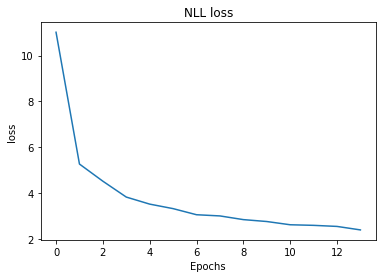

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

loss = []
for l in loss_list:
    loss.append(l[1])

plt.plot(epoch_list, loss)
plt.title('NLL loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.show()

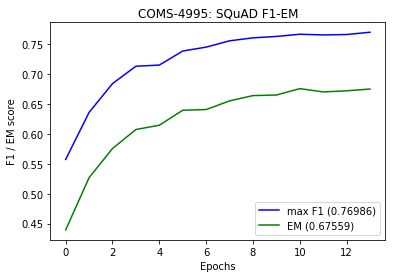

In [19]:
plt.plot(epoch_list, f1_list, 'b', label='max F1 (' + str(str(format(max(f1_list),'.5f'))+')'))
plt.plot(epoch_list, em_list, 'g', label='EM (' + str(str(format(max(em_list),'.5f'))+')'))
plt.title('COMS-4995: SQuAD F1-EM')
plt.xlabel('Epochs')
plt.ylabel('F1 / EM score')
plt.legend()
plt.show()

In [24]:
model_name_cur+'_predictions.preds'

'without_topics_final_1525717860_epoch_14_F1_76_99.mdl_predictions.preds'

In [21]:
reader.load_state_dict(torch.load("data/models/"+model_name_cur+'.pt'))
f1, em, results = validate(dev_loader, reader, dev_offsets, dev_texts, dev_answers, official=True)

with open("data/models/"+model_name_cur+'_predictions.preds','w') as f:
    json.dump(results, f)

In [22]:
f1

0.7698624255604388

In [23]:
em

0.6749261412370151

## On why questions

In [25]:
whys_id = []
whys = []
for sample in dev_exs:
    ques = [ques.lower() for ques in sample['question']]
    if 'why' in ques:
        whys_id.append(sample['id'])
        whys.append(sample)

In [26]:
#'who','when','why',''
why_offsets = {k: dev_offsets[k] for k in dev_offsets.keys() if k in whys_id}
why_texts = {k: dev_texts[k] for k in dev_texts.keys() if k in whys_id}
why_answers = {k: dev_answers[k] for k in dev_answers.keys() if k in whys_id}

#whys[0]

In [27]:
whys_dataset = Transform(whys, word2idx, char2idx,status='test')
whys_sampler = torch.utils.data.sampler.SequentialSampler(whys_dataset)
whys_loader = torch.utils.data.DataLoader(
        whys_dataset, batch_size=32, sampler=whys_sampler, num_workers=5, collate_fn=pad_batch, pin_memory=True,)

In [28]:
reader.load_state_dict(torch.load("data/models/"+model_name_cur+'.pt'))
f1, em, results = validate(whys_loader, reader, why_offsets, why_texts, why_answers, official=True)

In [29]:
f1

0.6586105288403903

In [30]:
em

0.35443037974683544

In [31]:
#lets look at some predictions
results

{'57337ddc4776f41900660bbe': 'to clean them of plants and sediments',
 '573399b54776f41900660e66': 'solid economic growth',
 '5733a32bd058e614000b5f36': 'their disastrous financial situation',
 '5733140a4776f419006606e4': 'because it has survived many wars, conflicts and invasions throughout its long history',
 '5733266d4776f41900660715': "Due to its central location between the Commonwealth's capitals of Kraków and Vilnius",
 '57332e48d058e614000b5763': 'Stalin was hostile to the idea of an independent Poland',
 '5733638fd058e614000b59e9': 'restored by the communist authorities after the war',
 '573368e54776f41900660a53': 'The species richness is mainly due to the location of Warsaw within the border region',
 '56e0c1617aa994140058e6d6': 'to attend school at the Higher Real Gymnasium',
 '56e0c2bc231d4119001ac389': 'this contact with nature made him stronger, both physically and mentally',
 '56dfa7887aa994140058dfaa': 'to hide the fact that he dropped out of school',
 '56dfaa047aa99414